# Kr analysis (run 3389)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import numpy as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Tue Apr  4 15:38:39 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 10, 8
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

#### Useful functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (41.5/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))

def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = os.environ["IC_DATA"] + "/Kr2016/data/3389/"

pattern = "$IC_DATA/*.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))

print("# files:", len(ifiles))

# files: 3000


### Define event class

In [5]:
class Event:
    """
    Store for relevant event info.
    """
    def __init__(self):
        self.nS1   = 0
        self.S1w   = []
        self.S1h   = []
        self.S1i   = []
        self.S1t   = []

        self.nS2   = 0
        self.S2w   = []
        self.S2h   = []
        self.S2i   = []

        self.Nsipm = []
        self.Q     = []
        self.Qsipm = []
        self.Xt    = np.nan
        self.Yt    = np.nan
        self.X     = np.nan
        self.Y     = np.nan
        self.Xrms  = np.nan
        self.Yrms  = np.nan
        self.Z     = np.nan
        self.R     = np.nan
        self.Phi   = np.nan

        self.T     = -1
        self.ok    = False

### Define dataset class

In [6]:
class Dataset:
    """
    Trick for accesing event properties as an attribute of the dataset.
    """
    def __init__(self, evts):
        self.evts = np.array(evts, dtype=object)
        self._create_attrs()
    
    @timefunc
    def _create_attrs(self):
        for attr in filter(lambda x: not x.endswith("__"), Event().__dict__):
            setattr(self, attr, np.array([getattr(evt, attr) for evt in self.evts]))

    def __getitem__(self, sel):
        return Dataset(self.evts[sel])

## Functions to fill the event and dataset classes

In [7]:
#@timefunc
def fill_evts(s1s, s2s, sis, evts_out, times, ifile=None):    
    evts = set(list(s1s.keys()) +
               list(s2s.keys()) +
               list(sis.keys()))
    nevt = len(evts)
    #print(ifile, nevt)
    for i, evt_number in enumerate(evts):
        evt = Event()
        s1  = s1s.get(evt_number, dict())
        s2  = s2s.get(evt_number, dict())
        si  = sis.get(evt_number, dict())
        
        evt.nS1 = 0
        evt.nS2 = len(s2)

        s1time = 0
        for peak, (t, e) in s1.items():
            sel  = e > 0.5
            t, e = t[sel], e[sel]
            if t.size < 5:
                continue
            evt.nS1 += 1
            evt.S1w.append(width(t))
            evt.S1h.append(np.max(e))
            evt.S1i.append(np.sum(e))
            s1time = t[np.argmax(e)]
            evt.S1t.append(s1time)
        
        s2time = 0
        for peak, (t, e) in s2.items():
            evt.S2w.append(width(t, to_mus=True))
            evt.S2h.append(np.max(e))
            evt.S2i.append(np.sum(e))
            s2time = t[np.argmax(e)]

            IDs, Qs = integrate_charge(si[peak]) if peak in si else ([], [])
            Qpeak   = np.sum(Qs)
            xsipms  = DataSiPM.X.values[IDs]
            ysipms  = DataSiPM.Y.values[IDs]

            evt.Qsipm.append(Qs)
            evt.Nsipm.append(len(IDs))
            evt.Q    .append(Qpeak)
            evt.X    = np.average(xsipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Y    = np.average(ysipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Xrms = (np.sum(Qs * (xsipms-evt.X)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.Yrms = (np.sum(Qs * (ysipms-evt.Y)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.R    = (evt.X**2 + evt.Y**2)**0.5 if np.any(Qs) else np.nan
            evt.Phi  = np.arctan2(evt.Y, evt.X) if np.any(Qs) else np.nan

        evt.T  = times[i]
        evt.ok = evt.nS1 == evt.nS2 == 1
        if evt.ok:
            evt.Z = (s2time - s1time) * units.ns / units.mus
        evts_out.append(evt)


@timefunc
def build_dataset(inputfiles):
    evts_out = []
    first    = True
    for ifile in inputfiles:
        s1s, s2s, sis = pmapf.read_pmaps(ifile)
        with tb.open_file(ifile) as h5f:
            times = h5f.root.Run.events.cols.timestamp[:] * 1e-3
        if first:
            t0 = np.min(times)
            first = False
            print("First event at t = {} s".format(t0))
        fill_evts(pmapf.df_to_pmaps_dict(s1s),
                  pmapf.df_to_pmaps_dict(s2s),
                  pmapf.df_to_s2si_dict (sis),
                  evts_out, times - t0, ifile)
    return Dataset(evts_out)


# Read data

In [9]:
full = build_dataset(ifiles)#[:1500])

First event at t = 1490298748.524 s
Time spent in _create_attrs: 9.817023992538452 s
Time spent in build_dataset: 687.7583029270172 s


In [8]:
def read_kdst(kdst_file_name):
    """Return the kdst as PD DataFrames."""
    with tb.open_file(kdst_file_name, 'r') as h5f:
        t   = h5f.root.KrEvent.KrEvent
        
        return (pd.DataFrame.from_records(t.read()))

kdst = read_kdst("/Users/Gonzalo/github/NEXTdata/kdst_3389_full.h5")

## General plots (no selections applied)

In [10]:
def save(*args):
    pass

## From now on the study is focused on those events with exactly one S1 and one S2

In [11]:
oneS1oneS2 = full[full.ok]
print("Full set   :",       full.evts.size, "events")
print("Reduced set:", oneS1oneS2.evts.size, "events")
print("Ratio      :", oneS1oneS2.evts.size/full.evts.size)

Time spent in _create_attrs: 9.456812143325806 s
Full set   : 489000 events
Reduced set: 309200 events
Ratio      : 0.6323108384458078


<b>
The ratio of "reliable" to total events is ~51.2%
</b>

# Distribution of events in Z

In [12]:
kdst.head()

,run,event,timestamp,peak,s1_energy,s2_energy,s1_epeak,s2_epeak,s1_tpeak,s2_tpeak,s1_width,s2_width,n_s1_pmt,n_sipm,Q_tp,x,y,z,r,phi
0,3389,4,1490298748807,0,8.223267,4310.023438,1.428076,1040.561646,486350.0,653012.5,250.0,9430.6250,0,1,43.343048,175.000000,15.000000,149.996246,175.641678,0.085505
1,3389,6,1490298749148,0,10.454070,5998.549316,1.702968,1844.077515,560750.0,652662.5,250.0,6003.0625,0,3,157.916245,-147.107529,-99.803894,82.721252,177.767944,-2.545482
2,3389,8,1490298749516,0,9.608479,5904.074219,2.148601,1819.046509,550000.0,652687.5,200.0,6021.3125,0,3,121.689034,-101.459969,11.094533,92.418747,102.064751,3.032676
3,3389,10,1490298750202,0,9.195723,6396.546387,2.001530,1760.124390,526500.0,653187.5,175.0,7850.0000,0,3,153.725143,121.761581,27.240410,114.018753,124.771484,0.220095
4,3389,12,1490298750532,0,11.618337,4470.354492,1.333540,1114.189697,492175.0,652712.5,350.0,8207.3125,0,2,85.080238,-110.719063,35.000000,144.483749,116.119385,2.835418


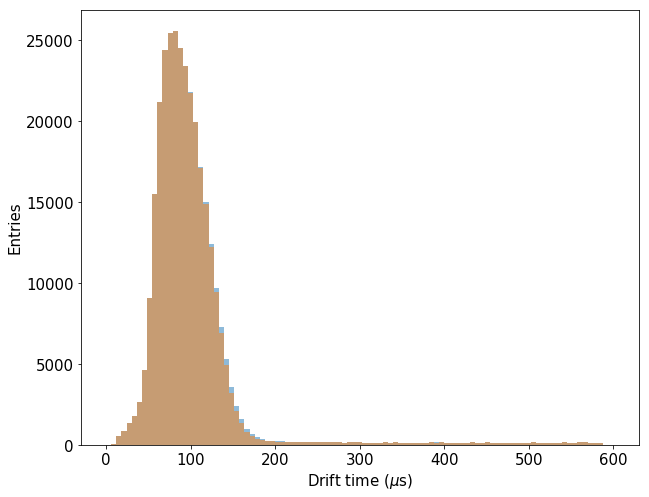

In [13]:
data = oneS1oneS2

bins = np.linspace(0, 600, 100)
hist(data.Z * 0.9, bins, alpha=0.5)
plt.hist(kdst.z, bins, alpha=0.5)
labels("Drift time ($\mu$s)", "Entries")
save("Z")

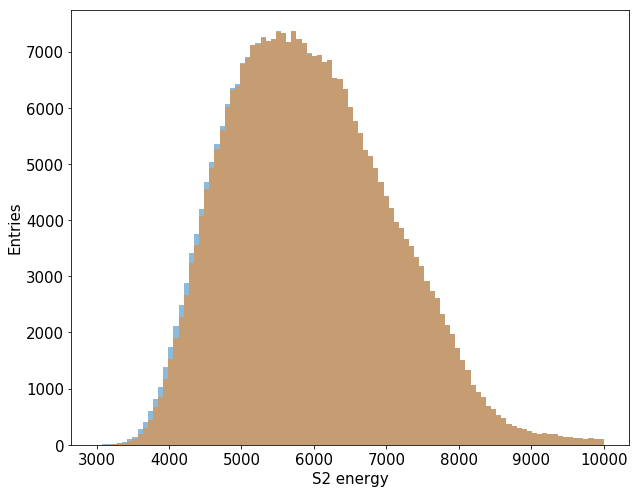

In [14]:
data = oneS1oneS2

bins = np.linspace(3e3, 1e4, 100)
hist(data.S2i, bins, alpha=0.5)
plt.hist(kdst.s2_energy, bins, alpha=0.5)
labels("S2 energy", "Entries")
save("Z")

<b>
Looks like there is an accumulation of events for Z < 200 $\mu$s and a flat distribution for Z > 200 $\mu$s.
</b>

# S2 energy vs Z

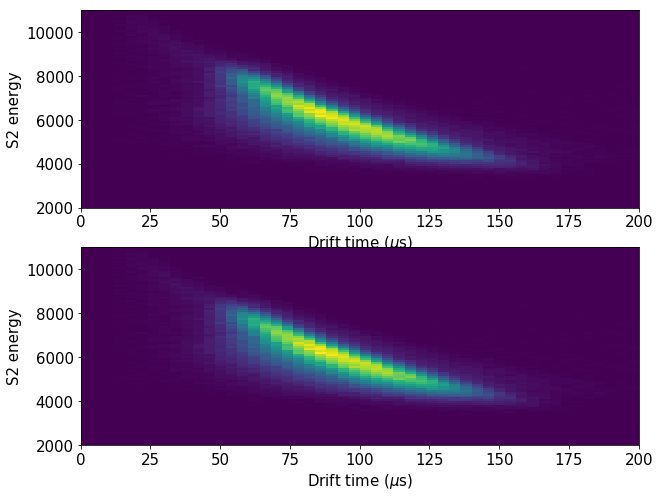

In [15]:
data = oneS1oneS2

zrange =   0, 200
Erange = 2e3, 11e3
plt.figure()

plt.subplot(2, 1, 1)
plt.hist2d(data.Z * 0.9, flat(data.S2i), (50, 100), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

plt.subplot(2, 1, 2)
plt.hist2d(kdst.z, kdst.s2_energy, (50, 100), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

# Short drift time: Z < 200 $\mu$s

In [16]:
shortZ = oneS1oneS2[oneS1oneS2.Z < 200]
kz     = kdst.loc[kdst.z < (200 * 0.9)]

Time spent in _create_attrs: 8.836963891983032 s


# S1 energy

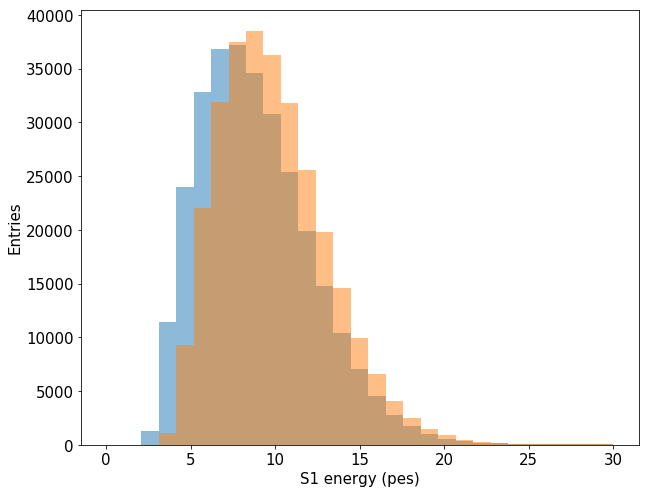

In [17]:
data = shortZ
s1i = flat(data.S1i)

bins = np.linspace(0, 30, 30)
hist(s1i, bins, alpha=0.5)
plt.hist(kz.s1_energy, bins, alpha=0.5)
labels("S1 energy (pes)", "Entries")
save("S1energy")


# S1 width

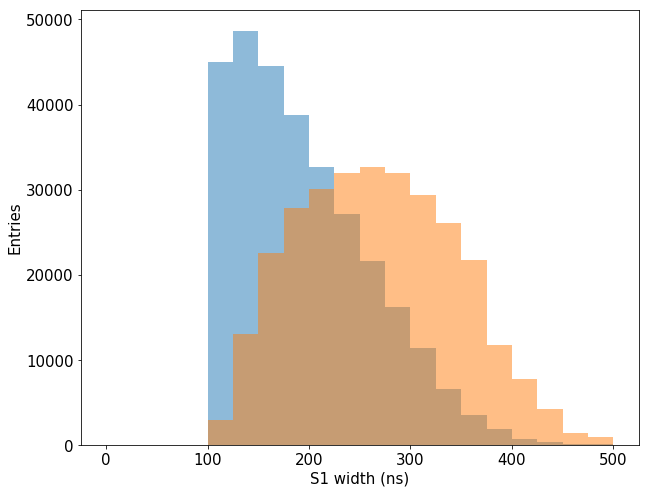

In [18]:
data = shortZ

zrange = 0, 200
wrange = 0, 500

s1w = flat(data.S1w)
bins = np.linspace(0, 500, 21)
hist(s1w, bins, alpha=0.5)
plt.hist(kz.s1_width, bins, alpha=0.5)
labels("S1 width (ns)", "Entries")

# S1 height

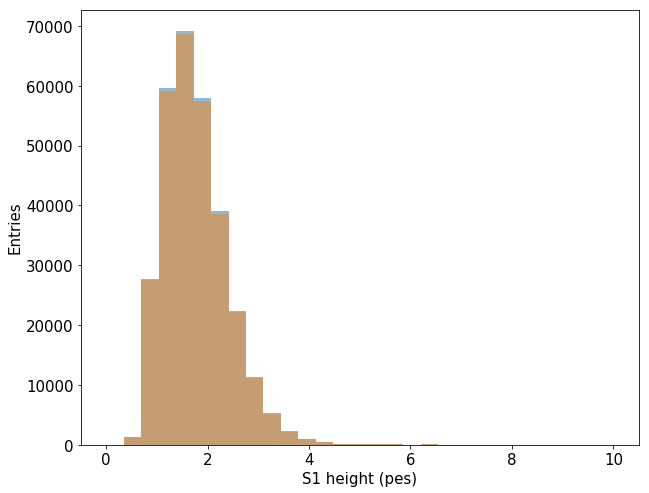

In [19]:
data = shortZ

zrange = 0, 200
hrange = 0, 10

bins = np.linspace(0, 10, 30)
s1h = flat(data.S1h)

hist(s1h, bins, alpha=0.5)
plt.hist(kz.s1_epeak, bins, alpha=0.5)
labels("S1 height (pes)", "Entries")


# S1 peak to area ratio

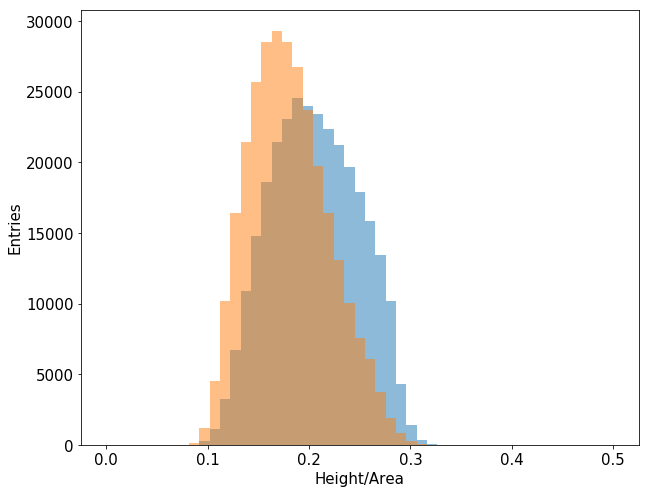

In [20]:
data = shortZ

zrange = 0, 200
rrange = 0, 0.5

s1r = flat(data.S1h)/flat(data.S1i)
bins = np.linspace(0, 0.5, 50)
hist(s1r, bins, alpha=0.5)
plt.hist(kz.s1_epeak/kz.s1_energy, bins, alpha=0.5)
labels("Height/Area", "Entries")


# S2 energy

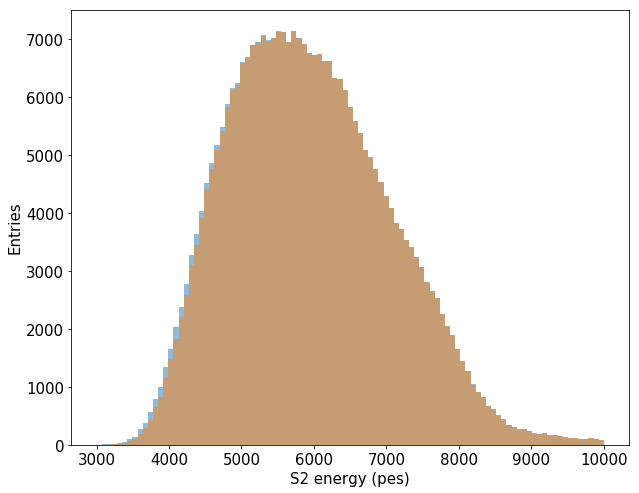

In [21]:
data = shortZ

zrange = 0, 200
Erange = 3e3, 9e3

s2i = flat(data.S2i)
bins = np.linspace(3e3, 1e4, 100)
hist(s2i, bins, alpha=0.5)
plt.hist(kz.s2_energy, bins, alpha=0.5)
labels("S2 energy (pes)", "Entries")

# S2 width

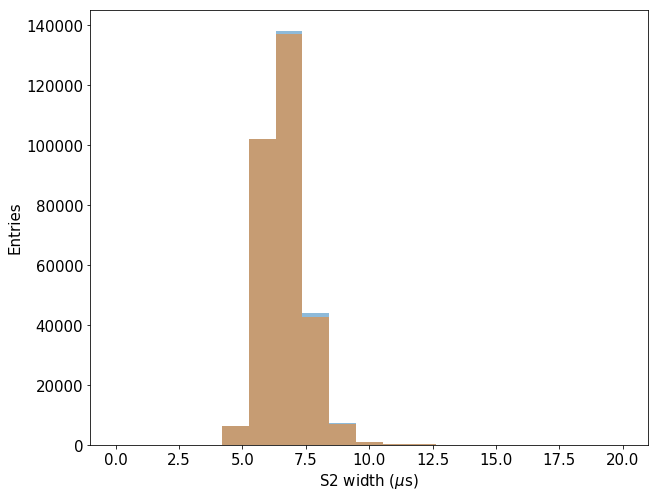

In [22]:
data = shortZ

zrange = 0, 200
wrange = 5, 15

s2w = flat(data.S2w)
bins = np.linspace(0, 20, 20)

hist(s2w, bins, alpha=0.5)
plt.hist(kz.s2_width * 1e-3, bins, alpha=0.5)
labels("S2 width ($\mu$s)", "Entries")

# S2 height

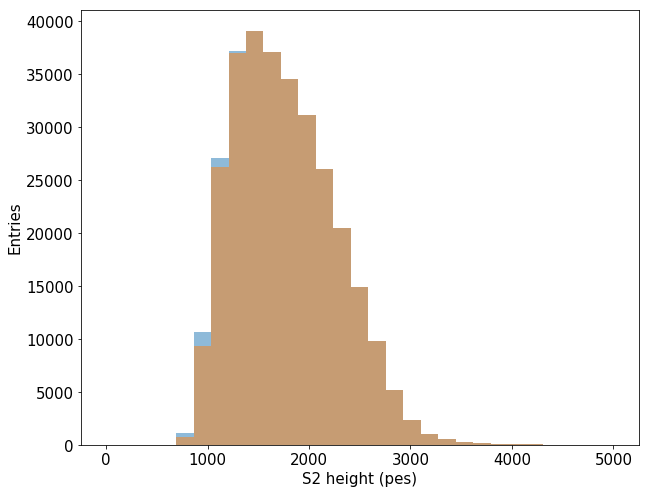

In [23]:
data = shortZ

zrange = 0, 200
hrange = 0, 5e3

s2h = flat(data.S2h)
bins = np.linspace(0, 5e3, 30)
hist(s2h, bins, alpha=0.5)
plt.hist(kz.s2_epeak, bins, alpha=0.5)
labels("S2 height (pes)", "Entries")

# S2 peak to area ratio

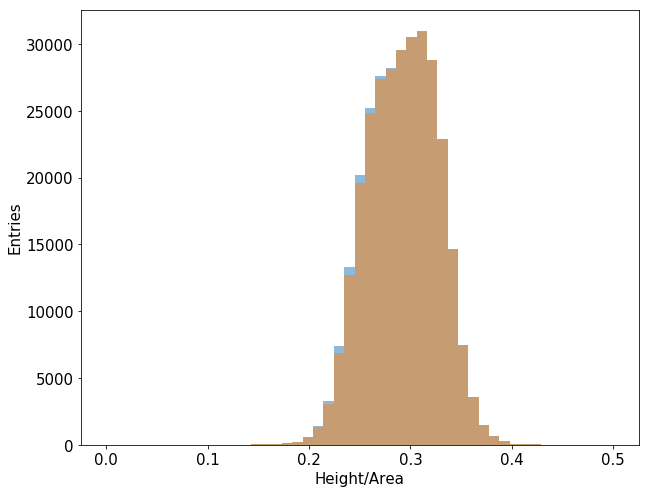

In [24]:
data = shortZ

zrange = 0, 200
rrange = 0, 0.5

s2r = flat(data.S2h)/flat(data.S2i)
bins = np.linspace(0, 0.5, 50)

hist(s2r, bins, alpha=0.5)
plt.hist(kz.s2_epeak/kz.s2_energy, bins, alpha=0.5)
labels("Height/Area", "Entries")

# S2 vs S1

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


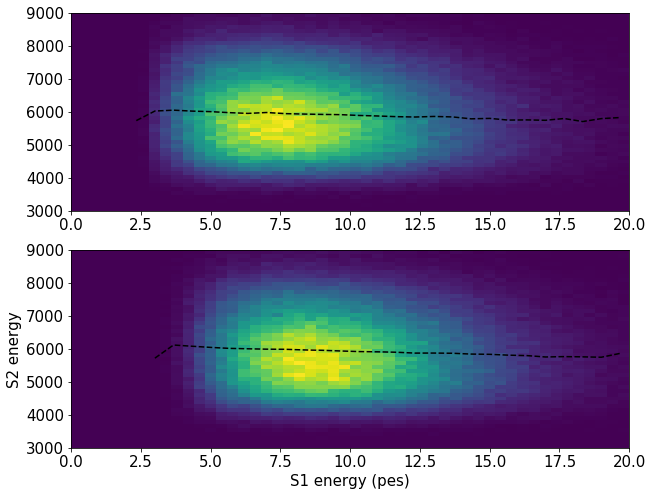

In [26]:
data = shortZ

Srange = 0, 20
Erange = 3e3, 9e3

S = flat(data.S1i)
E = flat(data.S2i)

plt.figure()
plt.subplot(2, 1, 1)
plt.hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

plt.subplot(2, 1, 2)
plt.hist2d(kz.s1_energy, kz.s2_energy, (50, 50), range=(Srange, Erange))
labels("S1 energy (pes)", "S2 energy")
x, y, _ = fitf.profileX(kz.s1_energy, kz.s2_energy, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)


# Temporary fiducialization

In [27]:
fiducialized = shortZ[shortZ.R < 100]
kr = kz.loc[kz.r < 100]

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


Time spent in _create_attrs: 2.783928155899048 s


# S2 energy fiducialized

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 11979.22349261   -140.35179423]
[ 11979.22228921   -140.35181184]


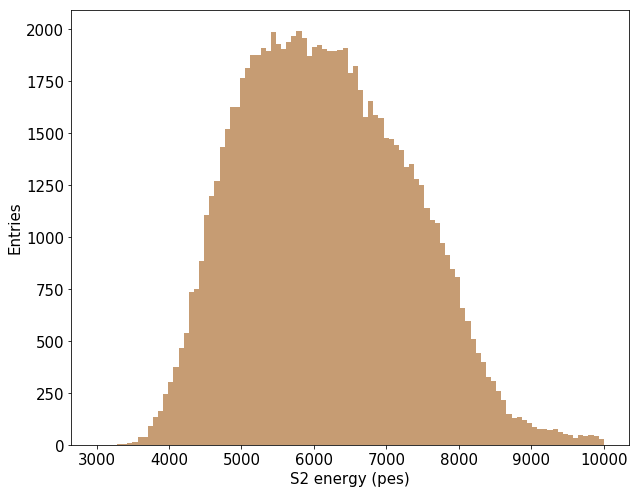

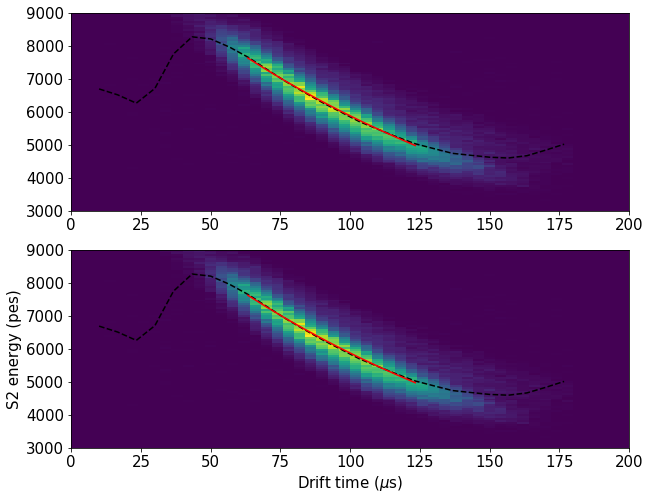

In [32]:
data = fiducialized

zrange = 0, 200
Erange = 3e3, 9e3

s2i = flat(data.S2i)

bins = np.linspace(3e3, 1e4, 100)
hist(s2i, bins, alpha=0.5)
plt.hist(kr.s2_energy, bins, alpha=0.5)
labels("S2 energy (pes)", "Entries")
save("S2energy_fiducial")

plt.figure()
plt.subplot(2, 1, 1)
plt.hist2d(data.Z * 0.9, s2i, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(data.Z * 0.9, s2i, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 60, 125)
x, y = x[sel], y[sel]
f1 = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f1.fn(x), fitOpt)
print(f1.values)

plt.subplot(2, 1, 2)
plt.hist2d(kr.z, kr.s2_energy, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(kr.z, kr.s2_energy, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 60, 125)
x, y = x[sel], y[sel]
f2 = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f2.fn(x), fitOpt)
print(f2.values)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ_fiducial")

zfun  = f1.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 7749.52582284 -4544.67823761]
[ 7749.52575349 -4544.68022783]


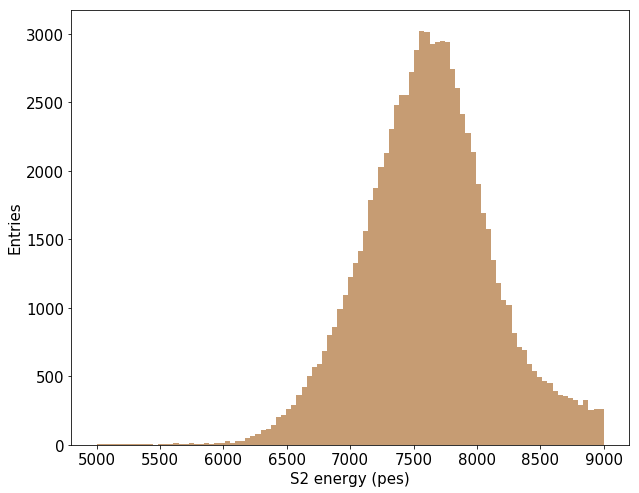

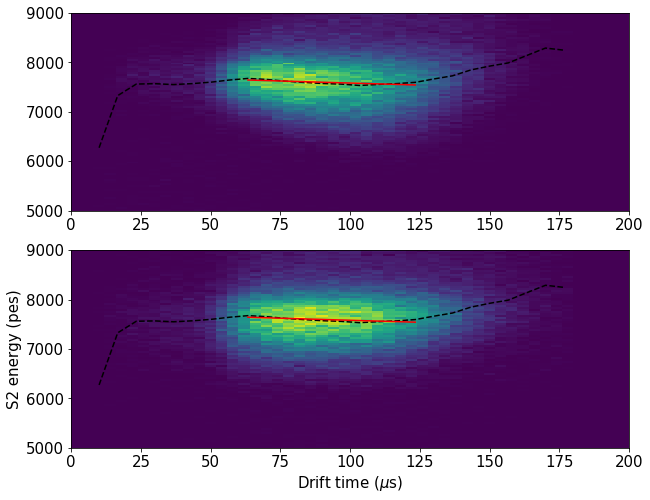

In [39]:
data = fiducialized

zrange = 0, 200
Erange = 5e3, 9e3
bins = np.linspace(5e3, 9e3, 100)

s2i = flat(data.S2i) * zcorr(data.Z * 0.9)
ez  = kr.s2_energy * zcorr(kr.z)

hist(s2i, bins, alpha=0.5)
plt.hist(ez, bins, alpha=0.5)
labels("S2 energy (pes)", "Entries")

plt.figure()
plt.subplot(2, 1, 1)
plt.hist2d(data.Z * 0.9, s2i, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(data.Z * 0.9, s2i, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 60, 125)
x, y = x[sel], y[sel]
f1 = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f1.fn(x), fitOpt)
print(f1.values)

plt.subplot(2, 1, 2)
plt.hist2d(kr.z, s2i, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(kr.z, ez, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 60, 125)
x, y = x[sel], y[sel]
f2 = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f2.fn(x), fitOpt)
print(f2.values)

labels("Drift time ($\mu$s)", "S2 energy (pes)")

# Tracking

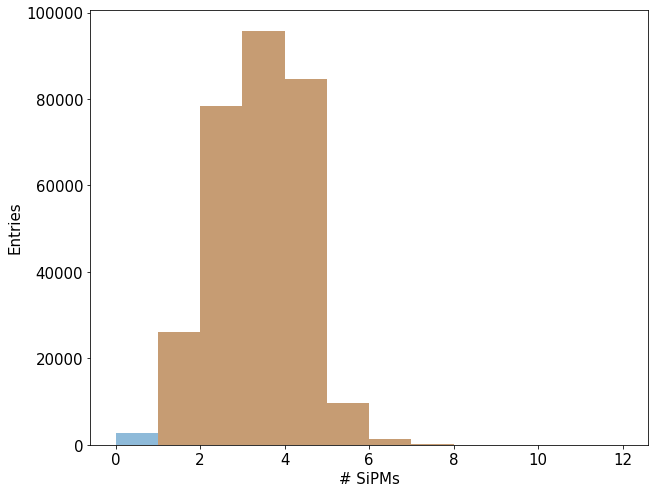

In [42]:
data = shortZ

nrange = 0, 12
zrange = 0, 600

nsipm = flat(data.Nsipm)

hist(nsipm, max(nrange), nrange, alpha=0.5)
plt.hist(kz.n_sipm, max(nrange), nrange, alpha=0.5)
labels("# SiPMs", "Entries")

# Take events with > 2 sipms, acceptable S2 energy and fiducialized to 180 mm

In [43]:
spread  = shortZ[(flat(shortZ.Nsipm) > 1) & (flat(shortZ.S2i) < 9000) & (flat(shortZ.R) < 180)]
kspread = kz.loc[(kz.n_sipm > 1) & (kz.s2_energy < 9e3) & (kz.r < 180)]

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


Time spent in _create_attrs: 6.70019793510437 s


# Event distribution

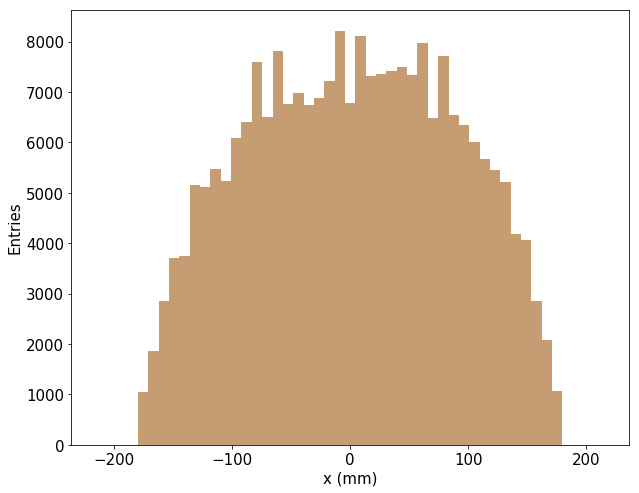

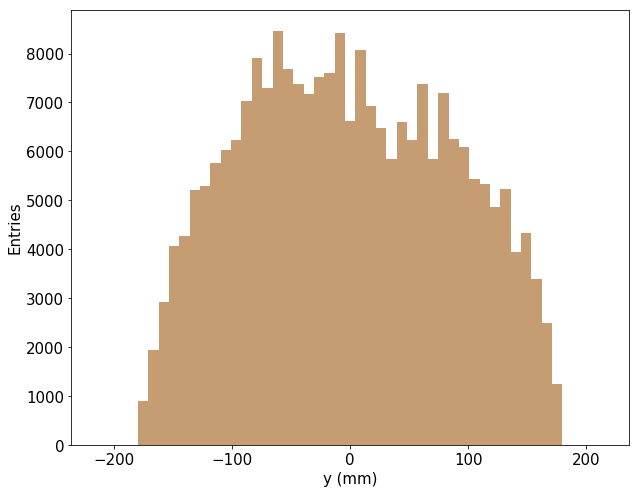

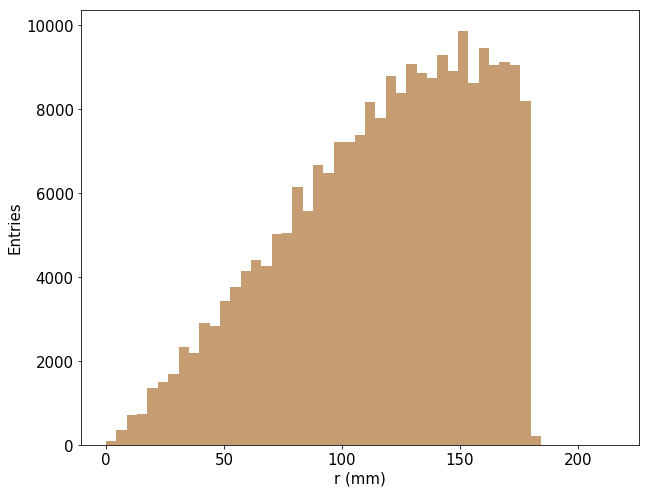

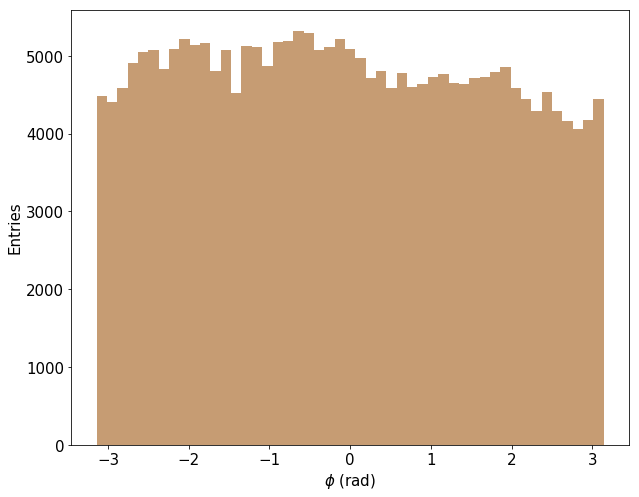

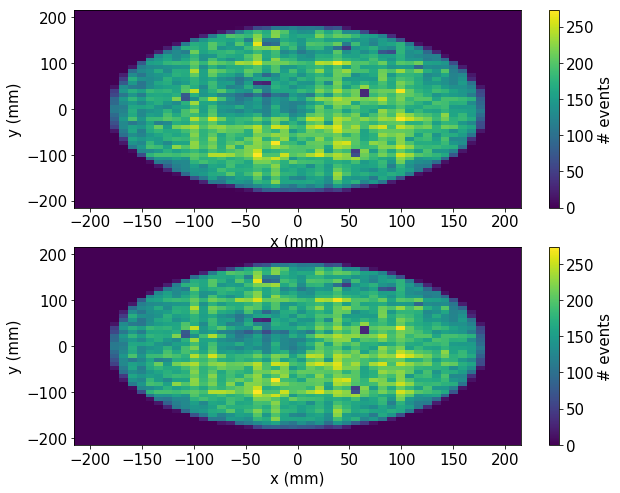

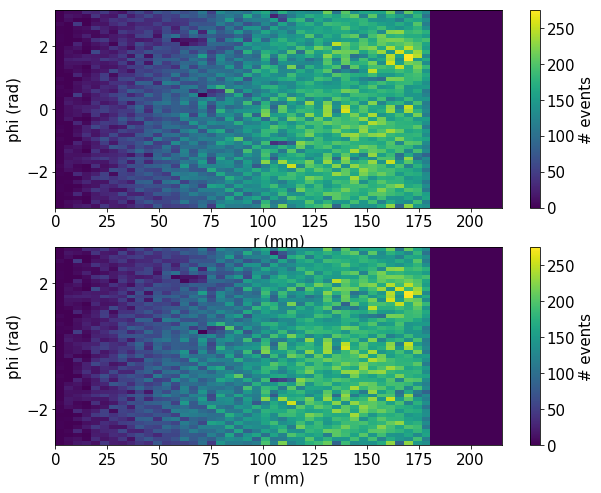

In [45]:
data = spread

xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

bins = np.linspace(-215, 215, 50)
hist(data.X, bins, alpha=0.5)
plt.hist(kspread.x, bins, alpha=0.5)
labels("x (mm)", "Entries")

hist(data.Y, bins, alpha=0.5)
plt.hist(kspread.y, bins, alpha=0.5)
labels("y (mm)", "Entries")

bins = np.linspace(0, 215, 50)
hist(data.R, bins, alpha=0.5)
plt.hist(kspread.r, bins, alpha=0.5)
labels("r (mm)", "Entries")

bins = np.linspace(-pi, pi, 50)
hist(data.Phi, bins, alpha=0.5)
plt.hist(kspread.phi, bins, alpha=0.5)
labels("$\phi$ (rad)", "Entries")

plt.figure()
plt.subplot(2,1,1)
plt.hist2d(data.X, data.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

plt.subplot(2,1,2)
plt.hist2d(kspread.x, kspread.y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")


plt.figure()
plt.subplot(2,1,1)
plt.hist2d(data.R, data.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "phi (rad)")

plt.subplot(2,1,2)
plt.hist2d(kspread.r, kspread.phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "phi (rad)")


# Tracking charge

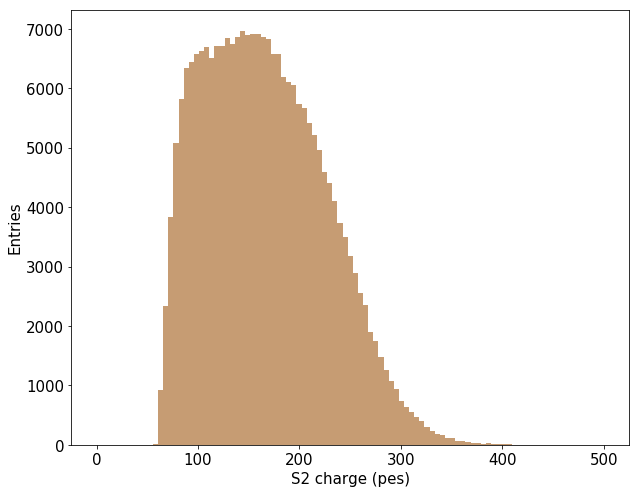

In [48]:
data = spread

zrange = 0, 200
Qrange = 0, 500
bins = np.linspace(0, 500, 100)

s2q = flat(data.Q)

hist(s2q, bins, alpha=0.5)
plt.hist(kspread.Q_tp, bins, alpha=0.5)
labels("S2 charge (pes)", "Entries")
save("S2charge")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


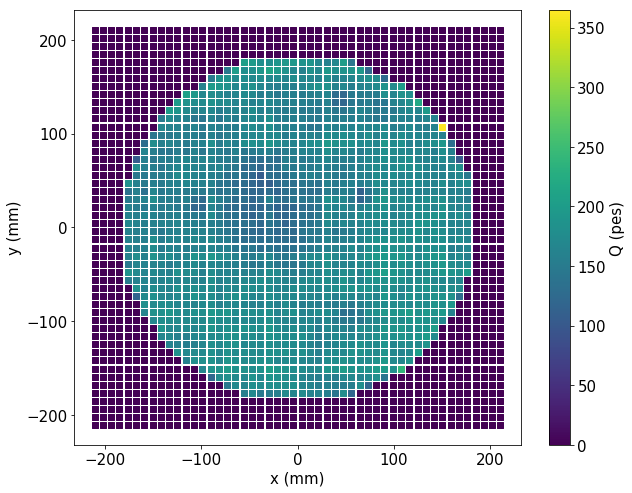

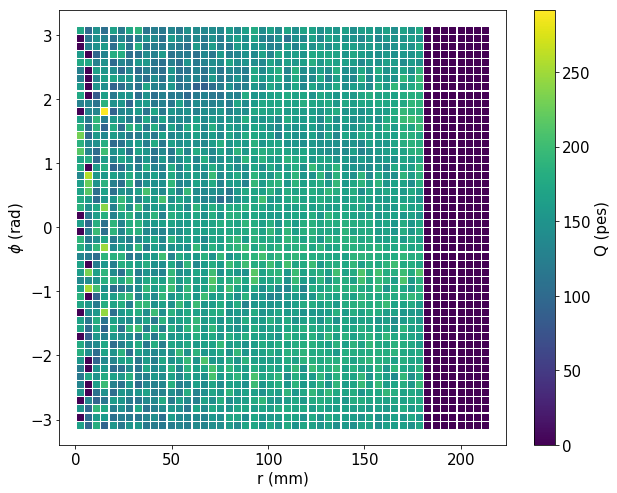

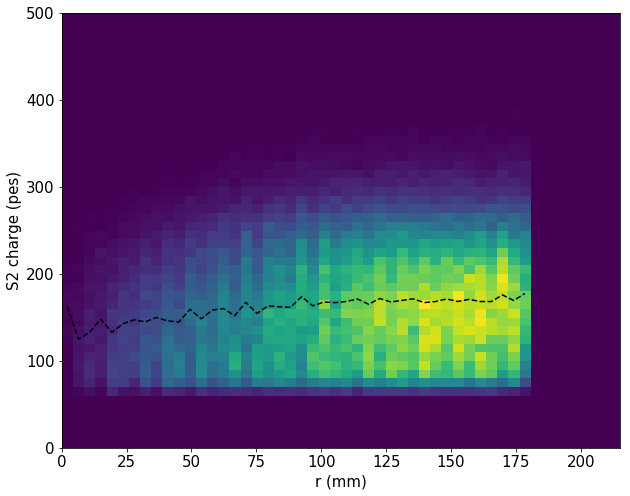

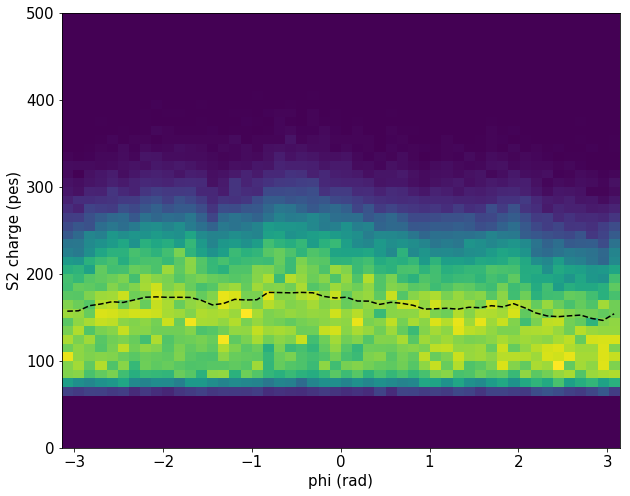

In [49]:
data = spread
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 500

Q  = flat(data.Q)
#Qw = Q/statcorr(data.X, data.Y)
#hist2d(data.X, data.Y, (50, 50), range=(xrange, yrange), weights=Qw, cmax=Qrange[1])
_, _, cb = profile_and_scatter(data.X, data.Y, Q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

#hist2d(data.R, data.Phi, (50, 50), range=(rrange, prange), weights=Qw, cmax=Qrange[1])
_, _, cb = profile_and_scatter(data.R, data.Phi, Q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(data.R, Q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(data.R, Q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(data.Phi, Q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(data.Phi, Q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


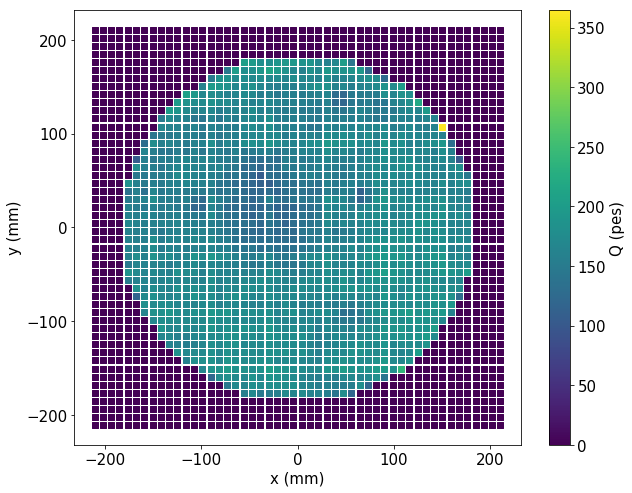

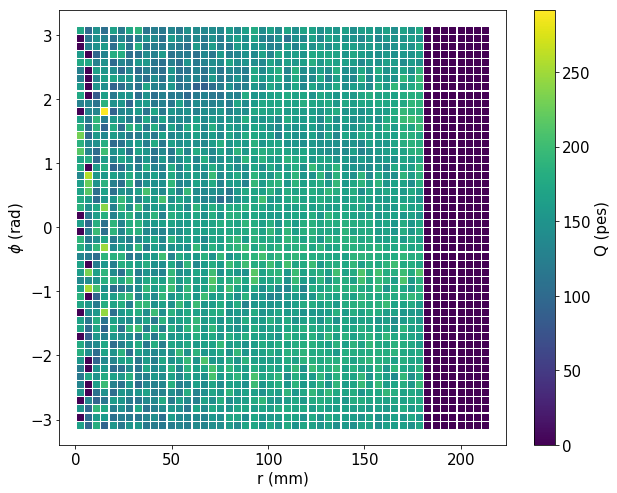

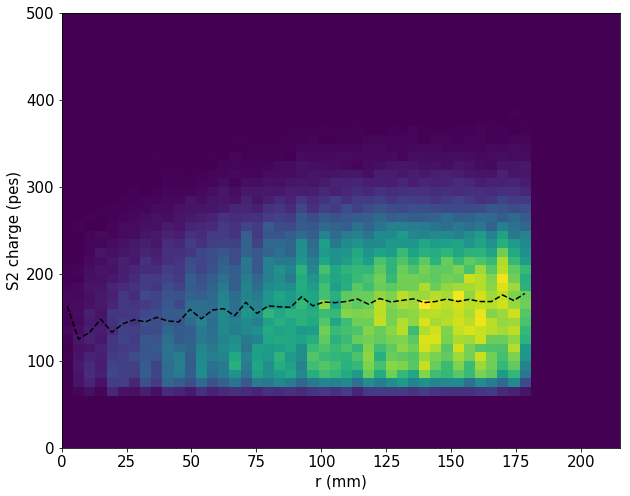

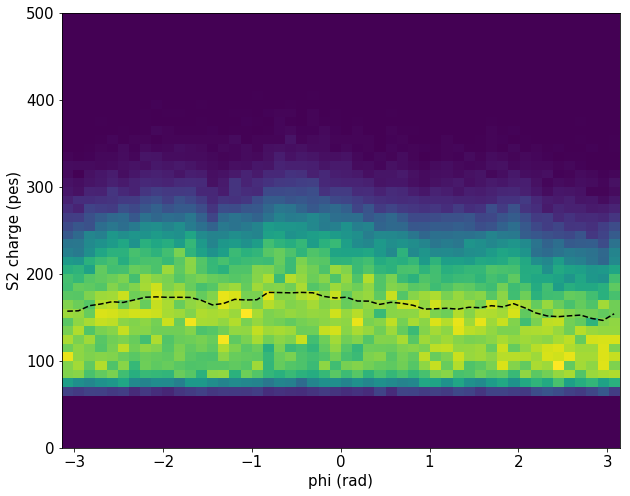

In [50]:
data = spread
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 500

Q  = kspread.Q_tp

_, _, cb = profile_and_scatter(kspread.x, kspread.y, Q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

_, _, cb = profile_and_scatter(kspread.r, kspread.phi, Q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(kspread.r, Q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(kspread.r, Q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(kspread.phi, Q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(kspread.phi, Q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8094.13393969


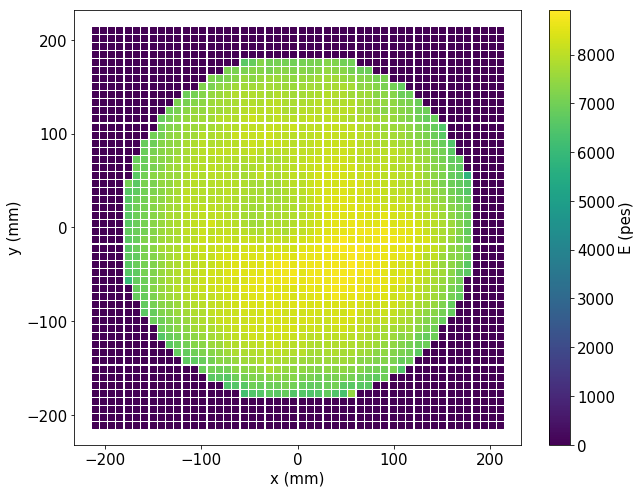

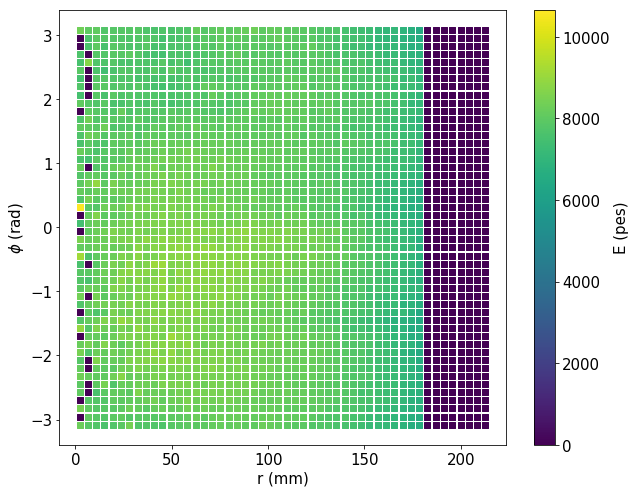

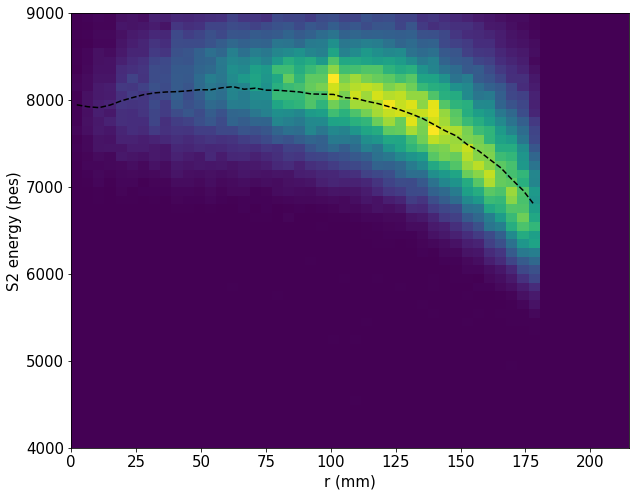

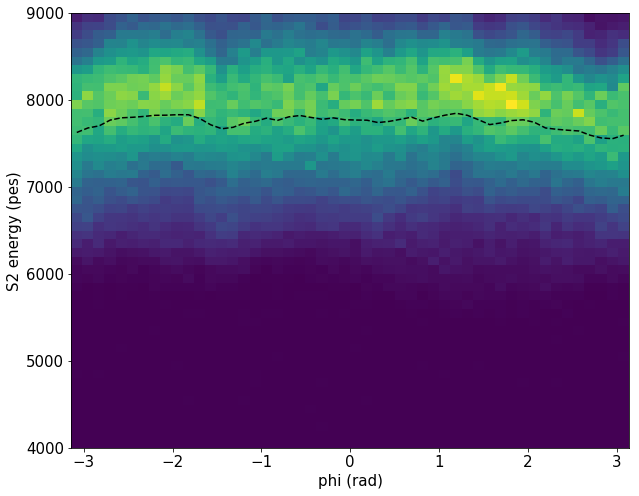

In [52]:
data   = spread
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E  = flat(data.S2i) * zcorr(data.Z)

pf, _, cb = profile_and_scatter(data.X, data.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(data.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(data.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(data.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(data.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

7544.5077169


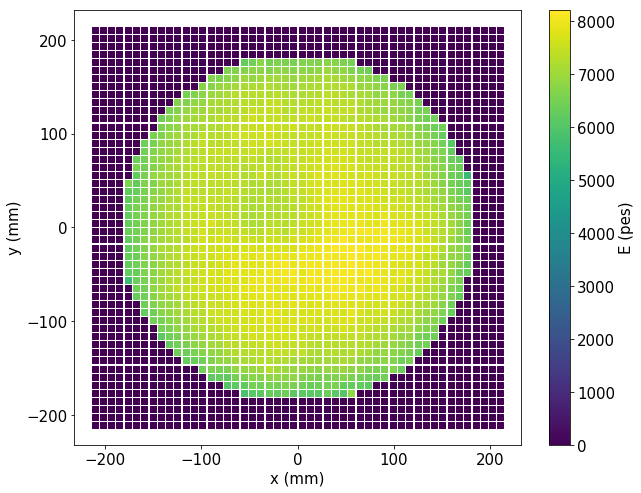

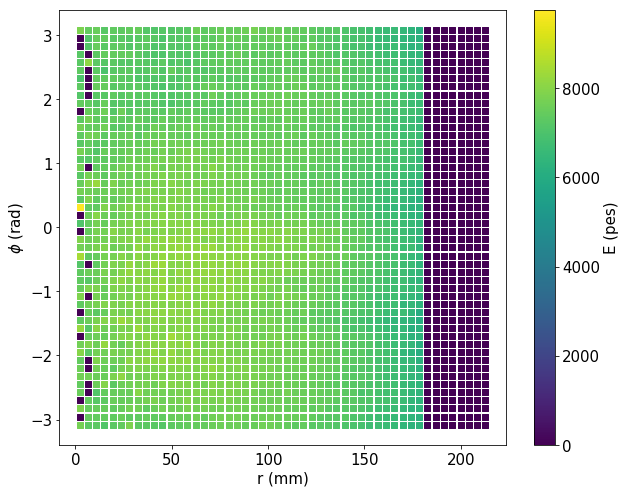

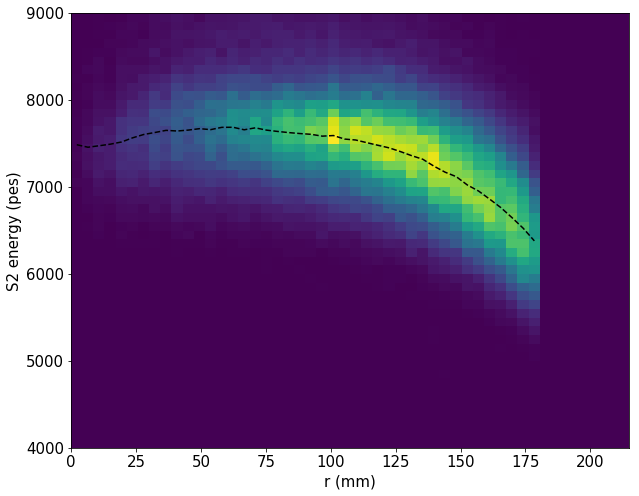

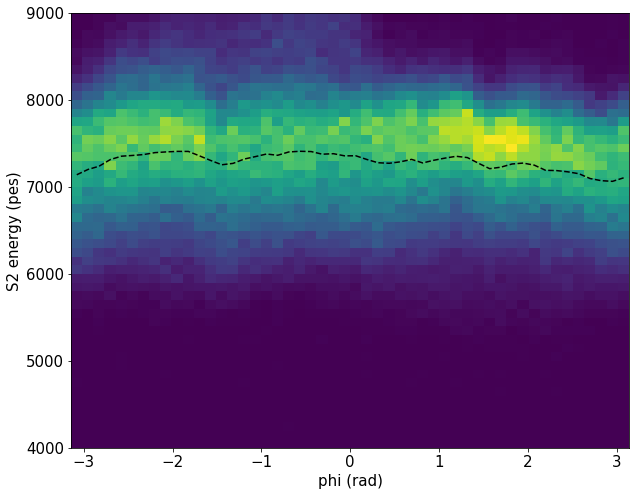

In [53]:
data   = spread
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E  = kspread.s2_energy * zcorr(kspread.z)

pf, _, cb = profile_and_scatter(kspread.x, kspread.y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(kspread.r, kspread.phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(kspread.r, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(kspread.r, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(kspread.phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(kspread.phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


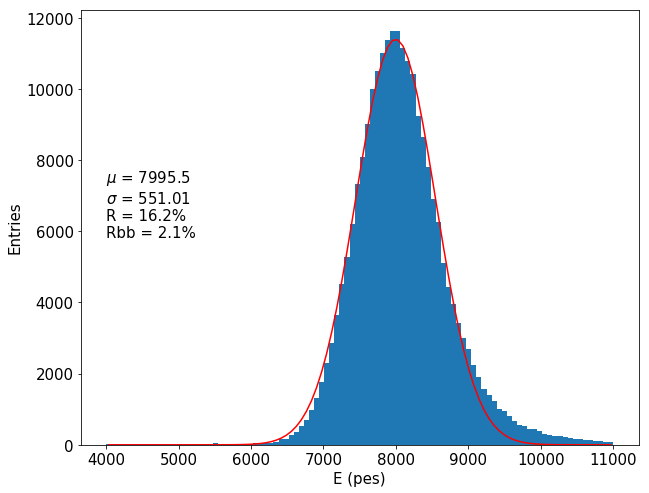

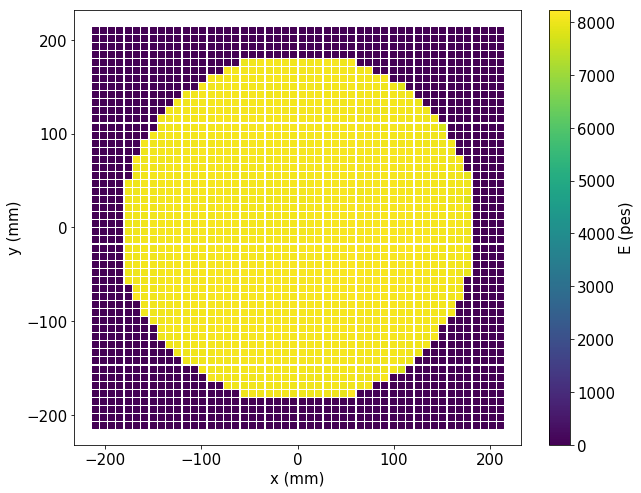

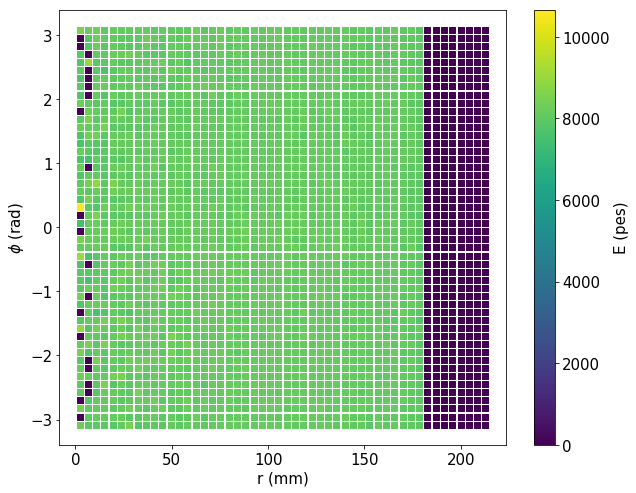

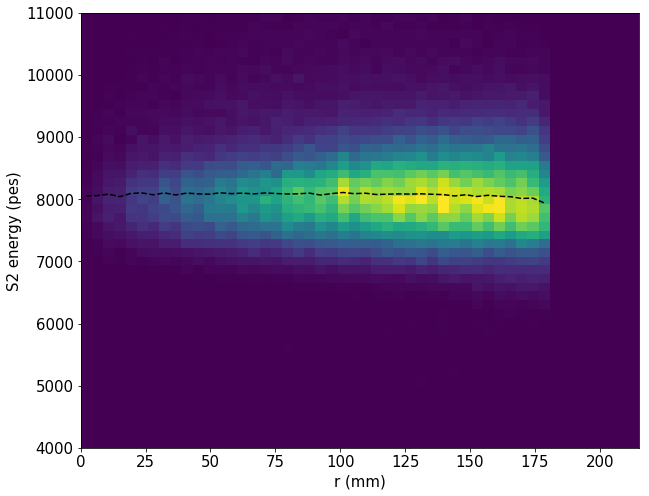

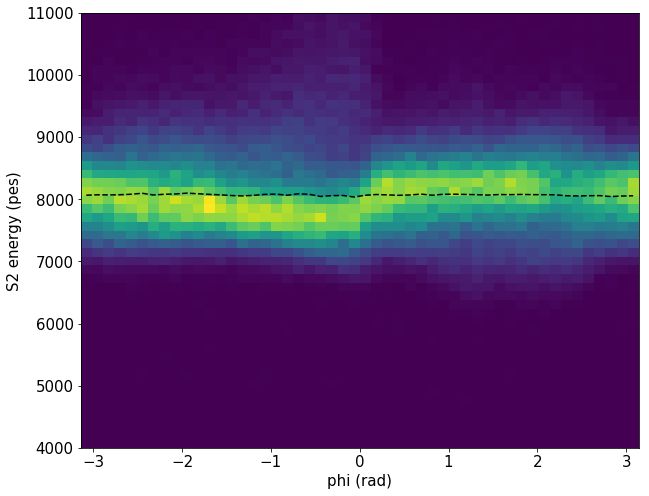

In [58]:
data   = spread
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3

E  = flat(data.S2i) * zcorr(data.Z) * xycorr(data.X, data.Y)
y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(data.X, data.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(data.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(data.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(data.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(data.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


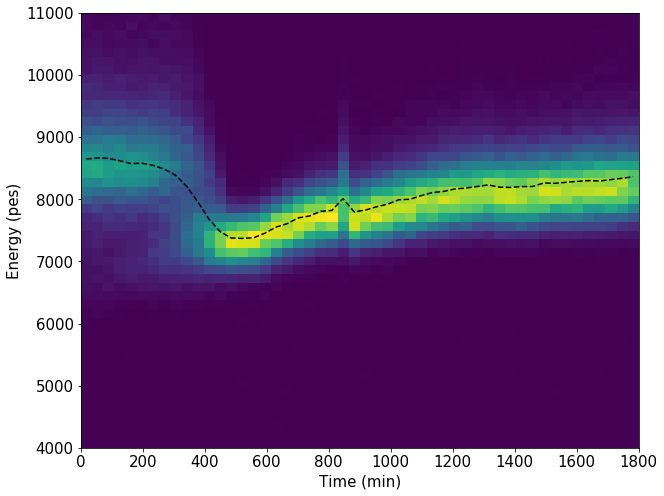

In [59]:
data   = spread
E      = flat(data.S2i) * zcorr(data.Z) * xycorr(data.X, data.Y)

Erange = 4e3, 11e3
Trange = 0, 1800

T = data.T/60

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

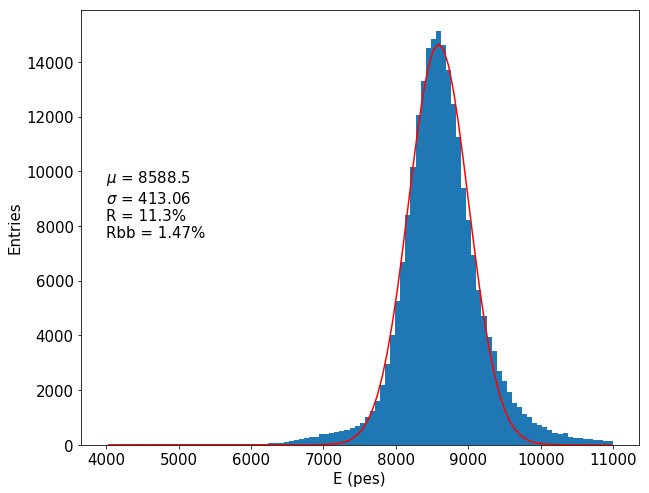

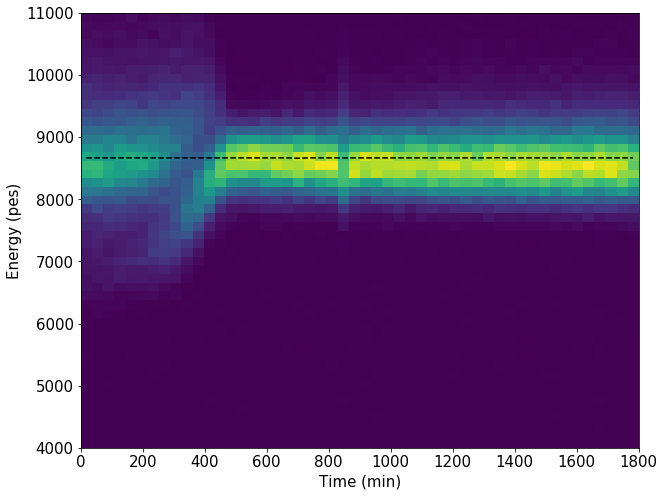

In [60]:
data   = spread
E      = flat(data.S2i) * zcorr(data.Z) * xycorr(data.X, data.Y) * tcorr(data.T/60)

Erange = 4e3, 11e3

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXYT")

T = data.T/60

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")


Time spent in _create_attrs: 3.073168992996216 s


/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


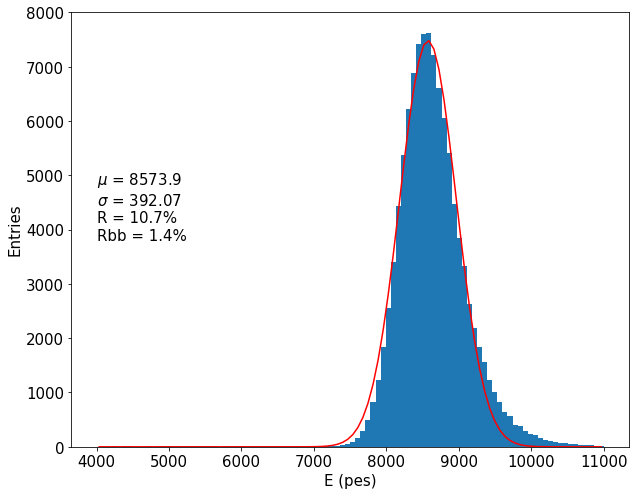

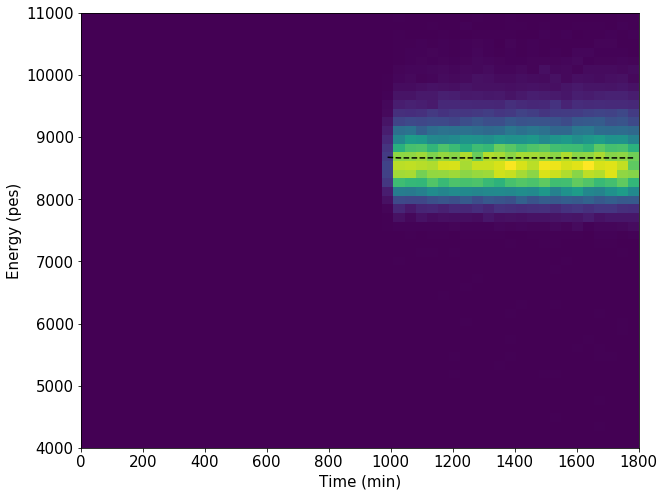

In [61]:
data   = spread[spread.T/60 > 1000]
E      = flat(data.S2i) * zcorr(data.Z) * xycorr(data.X, data.Y) * tcorr(data.T/60)

Erange = 4e3, 11e3

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")

T = data.T/60

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")
